In [1]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("/Users/sudhanshugupta/Library/Python/3.9/lib/python/site-packages")

In [4]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from EDA import EDA_movie_reviews
from preprocessing import preprocMovieReview, Vectorizer, train_val_test_split_movie_reviews
from classification import LogisticRegressionClassifier, BiLSTMClassifierWrapper

/Users/sudhanshugupta/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sudhanshugupta/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data

In [6]:
df_movie_reviews = pd.read_csv("./data/movie_review_train.tsv", delimiter="\t")
df_movie_reviews.sample(10)

,id,sentiment,review
19380,8416_1,0,It makes sense to me that this film is getting...
21576,6243_1,0,Don't drink the cool-aid.<br /><br />This is a...
9276,10273_8,1,I'm a big fan of films where people get conned...
23853,12123_1,0,"Recently, I had opportunity to view a working ..."
3168,1841_7,1,"Like his elder brothers, Claude Sautet and Jea..."
12814,3342_7,1,If you enjoy romantic comedies then you will f...
17578,12127_1,0,"Sorry Fulci fans, but I could not get through ..."
913,1181_9,1,Rachel Griffiths writes and directs this award...
17555,10777_9,1,"Radiofreccia is a movie about all of us, about..."
15037,6516_10,1,hello. i just watched this movie earlier today...


## Basic Text Preprocessing

In [7]:
text_preprocessor = preprocMovieReview(df_movie_reviews['review'])
df_movie_reviews['review_clean'] = text_preprocessor.basic_text_sanitization_pipeline()

/Users/sudhanshugupta/Documents/python_projects/cluepoints-case/preprocessing.py:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  html_parser = BeautifulSoup(review_text, "html.parser")


# Exploratory Data Analysis

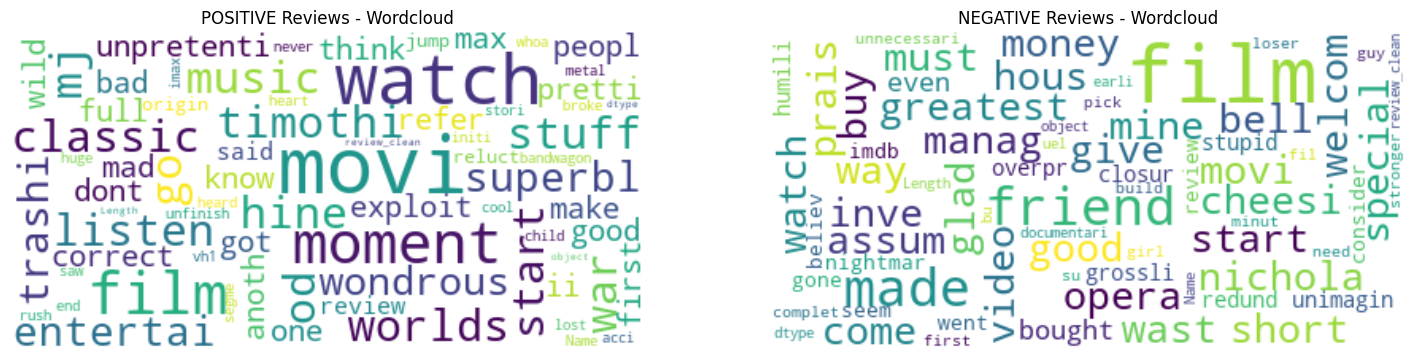

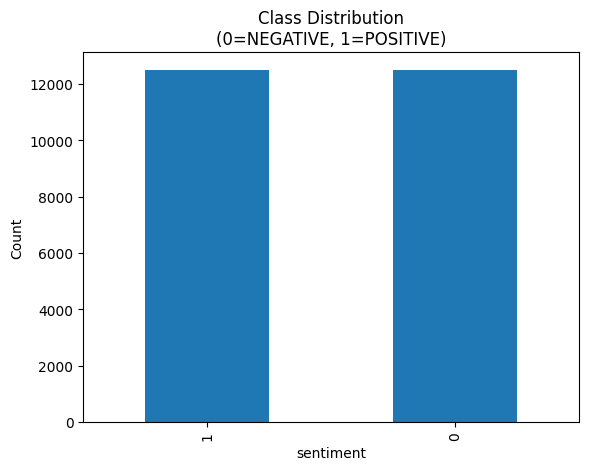

Statistics on count of tokens per POSITIVE movie review


count    12500.000000
mean       124.710960
std         97.135333
min          7.000000
25%         64.000000
50%         91.000000
75%        153.000000
max       1431.000000
Name: n_tokens, dtype: float64

Statistics on count of tokens per NEGATIVE movie review


count    12500.000000
mean       119.888880
std         88.148829
min          4.000000
25%         65.000000
50%         90.000000
75%        145.000000
max        836.000000
Name: n_tokens, dtype: float64

most common 5-grams for POSITIVE:
[(('one', 'best', 'movi', 'ever', 'seen'), 18), (('vote', 'eight', 'titl', 'brazil', '\\'), 12), (('vote', 'seven', 'titl', 'brazil', '\\'), 11), (('lion', 'king', '1', '1', '2'), 11), (('went', 'bought', 'case', 'cognac', 'went'), 11), (('bought', 'case', 'cognac', 'went', 'bought'), 11), (('case', 'cognac', 'went', 'bought', 'case'), 11), (('cognac', 'went', 'bought', 'case', 'cognac'), 11), (('\\', 'der', 'student', 'von', 'prag\\'), 10), (('dr', 'jacqu', 'coulardeau', 'univers', 'pari'), 9)]
most common 5-grams for NEGATIVE:
[(('one', 'worst', 'movi', 'ever', 'seen'), 76), (('one', 'worst', 'film', 'ever', 'seen'), 34), (('one', 'worst', 'movi', 'ever', 'made'), 24), (('worst', 'movi', 'ever', 'seen', 'life'), 13), (('one', 'worst', 'film', 'ever', 'made'), 12), (('\\', 'accord', 'dvd', 'sleev', 'synopsi'), 12), (('movi', 'ever', 'seen', 'entir', 'life'), 9), (('hour', 'life', 'never', 'get', 'back'), 9), (('minut', 'life', 'never', 'get', 'back'),

In [39]:
eda = EDA_movie_reviews(df_movie_reviews, reviews_col='review_clean', target_col='sentiment')
eda.visualize_wordcloud()
eda.visulaize_class_distribution()
eda.statistics_on_review_text()
eda.show_common_n_grams(n=5, show_count=10)

In [24]:
X_train, y_train, X_test, y_test, X_val, y_val = train_val_test_split_movie_reviews(df_movie_reviews, reviews_col='review_clean', target_col='sentiment', test_percent=20, val_percent=0)
print(f"{X_train.shape=}, {y_train.shape=}, {X_test.shape=}, {y_test.shape=}, {X_val.shape=}, {y_val.shape=}")

X_train.shape=(20000,), y_train.shape=(20000,), X_test.shape=(5000,), y_test.shape=(5000,), X_val.shape=(0,), y_val.shape=(0,)


# Establish Baseline: TFIDF Vectorizer + Basic Classifier

In [25]:
tfidf_vectorizer = Vectorizer(vectorizer_type='tfidf')
X_train = tfidf_vectorizer.apply_transform_train(X_train)
X_test = tfidf_vectorizer.apply_transform_test(X_test)

print(X_train.shape, X_test.shape)

(20000, 3571700) (5000, 3571700)


In [26]:
clf_logistic_regression = LogisticRegressionClassifier()
clf_logistic_regression.fit_classifier(X_train, y_train)
y_pred = clf_logistic_regression.predict_classifier(X_test)
clf_logistic_regression.evaluate_classifier(y_test, y_pred)

precision=0.8634241245136187
recall=0.8904494382022472
f1=0.876728565784275
accuracy=0.8752


# Improved Classifier: TFIDF Vectorizer + BiLSTM

In [29]:
# Example usage
input_size = X_train.shape[1]
hidden_size = 16
output_size = 2
num_epochs = 10
batch_size = 8
lr_init = 1e-3

clf_bilstm = BiLSTMClassifierWrapper(input_size, hidden_size, output_size, batch_size, num_epochs, lr_init)
clf_bilstm.fit_classifier(X_train, y_train)
y_pred = clf_bilstm.predict_classifier(X_test)
clf_bilstm.evaluate_classifier(y_test, y_pred)